In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
import math
import matplotlib.pyplot as plt

import numpy as np

from Load_Data import load_data

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using mps device


# Load Data

In [ ]:
def get_data_loaders(batch_size=64, faste_files_to_load=37, normalize=False):
    Data = load_data(data_dir=os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Mean'), 
                     train_val_data_to_load=math.inf,
                     test_data_to_load=math.inf,
                     faste_files_to_load=faste_files_to_load,
                     normalize=normalize)
    
    training_dataset, validation_dataset, testing_dataset = Data

    train_loader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=testing_dataset,
                              batch_size=batch_size,shuffle=True)
    return train_loader, val_loader, test_loader

faste_files_to_load = 37
normalize = False
train_loader, val_loader, test_loader = get_data_loaders(faste_files_to_load=faste_files_to_load, normalize=normalize)

Loading sequences from sequences.fasta
Loading coverage from SRX391990.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391996.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX1098138.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX391991.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX391995.faste
Loading coverage from SRX391997.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX1098137.faste
Loading coverage from SRX1098135.faste
Loading coverage from SRX1096550.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770790.

In [23]:
train_loader.dataset[100]


(tensor([[1., 0., 1.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0.0023, 0.0006, 0.0011, 0.0005, 0.0024, 0.0008, 0.0007, 0.0025, 0.0003,
         0.0010, 0.0004, 0.0008, 0.0004, 0.0018, 0.0004, 0.0008, 0.0005, 0.0009,
         0.0007, 0.0012, 0.0008, 0.0016, 0.0005, 0.0007, 0.0008, 0.0013, 0.0007,
         0.0003, 0.0005, 0.0008, 0.0007, 0.0006, 0.0006, 0.0003, 0.0024, 0.0013,
         0.0006]))

# Build Model

In [24]:
class DnaCnn(nn.Module):
    def __init__(self, num_kernels=[512, 256, 128], kernel_size=[1028,256,128],
                 dropout=0):
        super(DnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        # self.conv_block.append(nn.Sequential(
        #     nn.Conv1d(in_channels=self.num_kernels[0],
        #               out_channels=num_kernels[1],
        #               kernel_size=kernel_size[1]),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=2),
        #     nn.Dropout(p=self.dropout),            
        # ))
        # Add a third convolutional layer
        # self.conv_block.append(nn.Sequential(
        #     # second layer
        #     nn.Conv1d(in_channels=self.num_kernels[1],
        #               out_channels=num_kernels[2],
        #               kernel_size=kernel_size[2]),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=2),
        #     nn.Dropout(p=self.dropout),            
        # ))
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[0], 37),
            nn.ReLU(),  # ReLU ensures positive outputs
            # nn.LogSoftmax(dim=1)  # Apply log softmax if necessary for your task
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

In [35]:
class LocalDnaCnn(nn.Module):
    def __init__(self, num_kernels=[128, 64, 32, 16], kernel_size=[128,96,64,32],
                 dropout=0):
        super(LocalDnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        # Add a fourth convolutional layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[2],
                      out_channels=num_kernels[3],
                      kernel_size=kernel_size[3]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[3], num_kernels[3]),
            nn.Linear(num_kernels[3], faste_files_to_load),
            nn.ReLU(),  # ReLU ensures positive outputs
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

# Train Model

### Training functions

In [27]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
    validation_loss /= num_batches
    if epoch%10 == 0 :
        print(f"Validation Loss: {validation_loss:>8f} \n")
    return validation_loss

def train_model(train_loader, val_loader, model, optimizer, epochs, patience=10):
    loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
    p = patience

    train_loss = []
    validation_loss = []
    best_loss = math.inf
    for t in range(epochs):
        if t % 10 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
        train_loss.append(loss)
        loss = validation(val_loader, model, loss_fn, t)
        validation_loss.append(loss)
    
        if loss < best_loss:
            best_loss = loss    
            p = patience
        else:
            p -= 1
            if p == 0:
                print("Early Stopping!")
                break    
    print("Done!")

    def plot_loss(train_loss, validation_loss):
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(train_loss)), train_loss, label='Training')
        plt.plot(np.arange(len(validation_loss)), validation_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    plot_loss(train_loss, validation_loss)


### Train

Epoch 0
-------------------------------
training loss: 0.170305
Validation Loss: 0.012715 

Epoch 10
-------------------------------
training loss: 0.009806
Validation Loss: 0.008737 

Epoch 20
-------------------------------
training loss: 0.009760
Validation Loss: 0.008729 

Epoch 30
-------------------------------
training loss: 0.009701
Validation Loss: 0.008712 

Epoch 40
-------------------------------
training loss: 0.009625
Validation Loss: 0.008645 

Done!


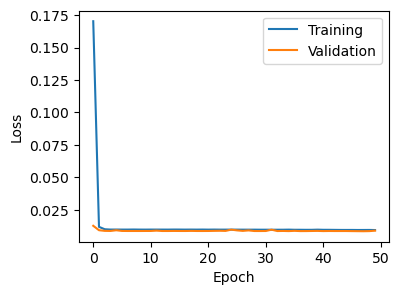

In [ ]:
model = LocalDnaCnn().to(device)
lr = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_model(train_loader, val_loader, model, optimizer, 50, 10)

### Save Model

In [8]:
torch.save(model, "model.pth")

### Validate Model

In [9]:
model = torch.load("model.pth", weights_only=False)
model.to(device)
model.eval()

LocalDnaCnn(
  (conv_block): Sequential(
    (0): Conv1d(4, 30, kernel_size=(50,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv1d(30, 30, kernel_size=(50,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (5): Sequential(
      (0): Conv1d(30, 30, kernel_size=(50,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (6): Sequential(
      (0): Conv1d(30, 30, kernel_size=(50,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
  )
  (regression_block): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=3, bias=True)
  )
)

In [31]:
X, y = next(iter(test_loader))
X = X.to(device)

y = y.to(device)
y_pred = torch.exp(model.forward(X).to(device))

print(y[0])
print(y_pred[0])

loss_fn = nn.PoissonNLLLoss(log_input=False, full=True)
print(loss_fn(y_pred, y))

tensor([0.0009, 0.0004, 0.0006, 0.0006, 0.0009, 0.0004, 0.0007, 0.0010, 0.0009,
        0.0005, 0.0006, 0.0003, 0.0001, 0.0000, 0.0006, 0.0007, 0.0003, 0.0004,
        0.0009, 0.0005, 0.0005, 0.0007, 0.0007, 0.0013, 0.0013, 0.0008, 0.0011,
        0.0005, 0.0007, 0.0003, 0.0010, 0.0010, 0.0003, 0.0014, 0.0008, 0.0007,
        0.0017], device='mps:0')
tensor([0.0016, 0.0024, 0.0019, 0.0024, 0.0015, 0.0015, 0.0018, 0.0014, 0.0022,
        0.0024, 0.0023, 0.0011, 0.0015, 0.0014, 0.0026, 0.0018, 0.0017, 0.0016,
        0.0018, 0.0010, 0.0013, 0.0012, 0.0027, 0.0022, 0.0020, 0.0010, 0.0021,
        0.0021, 0.0021, 0.0014, 0.0022, 0.0026, 0.0021, 0.0025, 0.0016, 0.0014,
        0.0023], device='mps:0', grad_fn=<SelectBackward0>)
tensor(0.0072, device='mps:0', grad_fn=<MeanBackward0>)


In [34]:
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 0.003, 0.004
1: 0.003, 0.000
2: 0.003, 0.001
3: 0.003, 0.001
4: 0.003, 0.004
5: 0.002, 0.001
6: 0.003, 0.001
7: 0.003, 0.004
8: 0.002, 0.000
9: 0.003, 0.001
10: 0.003, 0.001
11: 0.002, 0.001
12: 0.002, 0.001
13: 0.002, 0.000
14: 0.003, 0.001
15: 0.003, 0.001
16: 0.002, 0.001
17: 0.002, 0.001
18: 0.002, 0.001
19: 0.002, 0.002
20: 0.002, 0.001
21: 0.002, 0.002
22: 0.003, 0.000
23: 0.003, 0.001
24: 0.003, 0.001
25: 0.002, 0.002
26: 0.002, 0.001
27: 0.003, 0.001
28: 0.003, 0.001
29: 0.002, 0.001
30: 0.003, 0.001
31: 0.003, 0.001
32: 0.003, 0.001
33: 0.003, 0.001
34: 0.003, 0.004
35: 0.002, 0.002
36: 0.003, 0.001


In [12]:
Data = load_data(os.path.join(os.getcwd(), 'Data', 'Parsed_Data'), 
                 train_val_data_to_load=1, 
                 test_data_to_load=math.inf,
                 normalize=normalize,
                 faste_files_to_load=faste_files_to_load)

training_dataset, validation_dataset, testing_dataset = Data


Loading sequences from sequences.fasta
Loading coverage from SRX391990.faste


KeyboardInterrupt: 

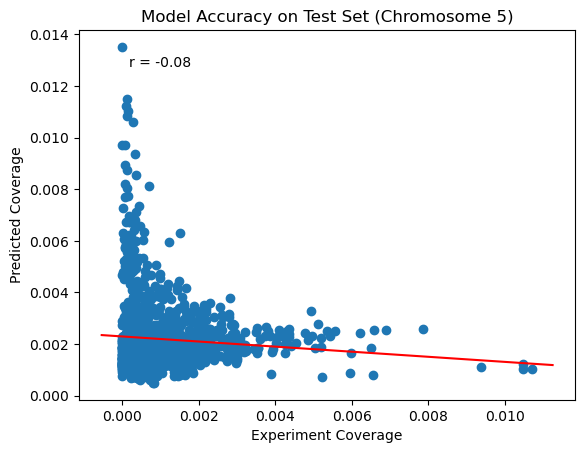

In [29]:
for _, (X, y) in enumerate(test_loader):
    X, y = X.to(device), y
    y_pred = torch.exp(model(X).to(device))

y = torch.flatten(y).cpu().numpy()
y_pred = torch.flatten(y_pred).cpu().detach().numpy()
pearson_r = np.corrcoef(y, y_pred)[0, 1]

plt.scatter(y, y_pred)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.show()